In [1]:
# # We always start with a dataset to train on. Let's download the tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
# hyperparameters
batch_size = 8 # how many independent sequences will we process in parallel?
block_size = 16 # what is the maximum context length for predictions?
max_iters = 2#000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50
n_embd = 64
n_head = 8
n_layer = 4
dropout = 0.0
training = True
# ------------

torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
dense_ffn_params = sum(p.numel() for p in model.blocks[0].ffwd.parameters()) 
print(f"Dense FFN parameters: {dense_ffn_params:,}")



# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.208705 M parameters
Dense FFN parameters: 33,088
step 0: train loss 4.3402, val loss 4.3471
step 1: train loss 4.1937, val loss 4.1881


In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.nn import Parameter
import math


# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
# hyperparameters
batch_size = 8 # how many independent sequences will we process in parallel?
block_size = 16 # what is the maximum context length for predictions?
max_iters = 2
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
num_experts = 16
top_k = 2
# ------------

torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss, total_loss,_ = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head,num_experts, top_k, dropout=0.1):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        ff_hidden_dim = max(8, (4 * n_embd) // num_experts)  #max(32, (4 * n_embd) // (num_experts // 4)) 
        self.sa = MultiHeadAttention(n_head, head_size)
        self.moe = SparseMoE(n_embd, ff_hidden_dim, n_embd, num_experts, top_k, dropout=dropout)
        # self._aux_loss = {}

        # self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        # MoE feedforward with residual connection
        moe_out, aux_loss = self.moe(self.ln2(x))
        x = x + moe_out
        # self._aux_loss = aux_loss 
        
        return x, aux_loss


    def get_balance_loss(self):
        loss = self._balance_loss
        self._balance_loss = 0.0 
        return loss



class Expert(nn.Module):
    """Individual expert network - a simple feedforward network"""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class TopKGate(nn.Module):
    """
    Gating network with capacity constraints, next-best assignment, and auxiliary loss
    to minimize token drops during training.
    """
    def __init__(self, input_dim, num_experts, top_k=2, capacity_factor=1.5):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.capacity_factor = capacity_factor  # 1.5 is reasonable - not too wasteful
        self.gate = nn.Linear(input_dim, num_experts, bias=True)
        nn.init.zeros_(self.gate.bias)  # Start with equal expert probability
        self.noise_epsilon = 1e-2
        
        # Auxiliary loss weights
        self.load_balance_weight = 0.01
        self.drop_penalty_weight = 1.0  # Strong penalty for drops
        self.router_balance_weight = 1e-4
        
    def calculate_expert_capacity(self, num_tokens):
        """Calculate per-expert capacity based on total tokens"""
        base_capacity = num_tokens // self.num_experts
        return int(base_capacity * self.capacity_factor)
    
    def assign_tokens_with_capacity(self, gate_probs, expert_capacity):
        """
        Assign tokens to experts with capacity constraints using next-best strategy
        
        Returns:
            assignments: tensor of shape (num_tokens,) with expert indices (-1 for dropped)
            expert_masks: tensor of shape (num_tokens, num_experts) for routing
            assignment_probs: tensor of shape (num_tokens,) with routing probabilities
        """
        num_tokens, num_experts = gate_probs.shape
        expert_counts = torch.zeros(num_experts, device=gate_probs.device, dtype=torch.long)
        assignments = torch.full((num_tokens,), -1, device=gate_probs.device, dtype=torch.long)
        assignment_probs = torch.zeros(num_tokens, device=gate_probs.device)
        
        # Sort all tokens by their maximum gate probability (process confident assignments first)
        max_probs, _ = gate_probs.max(dim=1)
        sorted_token_indices = torch.argsort(max_probs, descending=True)
        dropped_tokens_count = 0
        
        for token_idx in sorted_token_indices:
            token_probs = gate_probs[token_idx]
            # Get all experts sorted by preference (not just top-k)
            expert_preferences = torch.argsort(token_probs, descending=True)
            
            assigned = False
            
            # First, try the top-k experts
            for rank, expert_idx in enumerate(expert_preferences[:self.top_k]):
                if expert_counts[expert_idx] < expert_capacity:
                    assignments[token_idx] = expert_idx
                    assignment_probs[token_idx] = token_probs[expert_idx]
                    expert_counts[expert_idx] += 1
                    assigned = True
                    break
            
            # If top-k experts are all full, try next-best available experts
            if not assigned:
                dropped_tokens_count += 1
                for expert_idx in expert_preferences[self.top_k:]:
                    if expert_counts[expert_idx] < expert_capacity:
                        assignments[token_idx] = expert_idx
                        assignment_probs[token_idx] = token_probs[expert_idx]
                        expert_counts[expert_idx] += 1
                        assigned = True
                        break
            
            # If still not assigned, token will be dropped (assignments[token_idx] remains -1)
        
        # Create expert masks for routing
        expert_masks = torch.zeros(num_tokens, num_experts, device=gate_probs.device)
        valid_assignments = assignments >= 0
        expert_masks[valid_assignments, assignments[valid_assignments]] = 1.0
        
        return assignments, expert_masks, assignment_probs, expert_counts,dropped_tokens_count
    
    def calculate_auxiliary_losses(self, gate_probs, assignments, expert_counts,dropped_tokens_count):
        """Calculate all auxiliary losses"""
        num_tokens = gate_probs.shape[0]
        
        # 1. Load Balance Loss (encourage uniform expert usage)
        mean_gate = gate_probs.mean(dim=0)
        cv_squared = gate_probs.var(dim=0) / (mean_gate + 1e-8)
        load_balance_loss = cv_squared.mean()
        
        # 2. Drop Penalty Loss (heavily penalize dropped tokens)
        num_dropped = (assignments == -1).sum().float()
        drop_rate = dropped_tokens_count / num_tokens
        drop_penalty_loss = drop_rate  # Linear penalty on drop rate
        
        # 3. Capacity Utilization Loss (encourage using available capacity)
        target_capacity = num_tokens // self.num_experts
        capacity_diff = expert_counts.float() - target_capacity
        capacity_imbalance = (capacity_diff ** 2).mean()
        
        # 4. Router Z-Loss (from PaLM paper - prevents logit scale explosion)
        router_z_loss = torch.logsumexp(gate_probs, dim=-1).pow(2).mean()
        
        return {
            'load_balance_loss': load_balance_loss,
            'drop_penalty_loss': drop_penalty_loss,
            'capacity_imbalance': capacity_imbalance,
            'router_z_loss': router_z_loss,  # Small weight
            'drop_rate': drop_rate,
            'num_dropped': num_dropped.item(),
            'num_dropped_pre_next_best': dropped_tokens_count
        }
    
    def forward(self, x):
        """
        Forward pass with capacity constraints
        
        Returns:
            expert_masks: (batch_size * seq_len, num_experts) - binary masks for routing
            assignment_probs: (batch_size * seq_len,) - probabilities for assigned experts
            aux_losses: dict of auxiliary losses and metrics
        """
        batch_size, seq_len, input_dim = x.shape
        num_tokens = batch_size * seq_len
        x_flat = x.view(-1, input_dim)
        
        # Calculate expert capacity
        expert_capacity = self.calculate_expert_capacity(num_tokens)
        
        # Gate computation
        gate_logits = self.gate(x_flat)
        
        # Add noise during training for exploration
        if self.training:
            gate_logits += torch.randn_like(gate_logits) * self.noise_epsilon
        
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # Assign tokens to experts with capacity constraints
        assignments, expert_masks, assignment_probs, expert_counts, dropped_tokens_count = self.assign_tokens_with_capacity(gate_probs, expert_capacity)
        
        # Calculate auxiliary losses
        aux_losses = self.calculate_auxiliary_losses(gate_probs, assignments, expert_counts,dropped_tokens_count)
        effective_lb_weight = self.load_balance_weight * (self.top_k / 2) # Scale based on top_k

        # Combine losses with weights
        total_aux_loss = (
            effective_lb_weight * aux_losses['load_balance_loss'] +
            self.drop_penalty_weight * aux_losses['drop_penalty_loss'] +
             self.router_balance_weight * aux_losses['router_z_loss']
        )
        aux_losses['total_aux_loss'] = total_aux_loss
        # Monitor drop rates
        # if aux_losses['drop_rate'] > 0.05:  # More than 5% drops
        #     print(f"Warning: High drop rate {aux_losses['drop_rate']:.2%}")
        
        return expert_masks, assignment_probs, aux_losses






class SparseMoE(nn.Module):
    """Sparse Mixture of Experts Layer"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts=8, top_k=2, 
                 capacity_factor=1.25, dropout=0.1):
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Create expert networks
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim, dropout) 
            for _ in range(num_experts)
        ])
        
        # Gating network
        self.gate = TopKGate(input_dim, num_experts, top_k, capacity_factor)
        
    def forward(self, x):
        batch_size, seq_len, input_dim = x.shape
        x_flat = x.view(-1, input_dim)  # (batch_size * seq_len, input_dim)
        
        # Get routing decisions from gate
        # expert_indices, expert_weights, balance_loss = self.gate(x)
        expert_masks, assignment_probs, aux_losses = self.gate(x)
        
        # Initialize output
        output = torch.zeros(x_flat.shape[0], self.output_dim, 
                           device=x.device, dtype=x.dtype)

        
        # Process tokens through assigned experts
        for expert_idx, expert in enumerate(self.experts):
            # Find tokens assigned to this expert
            expert_tokens = expert_masks[:, expert_idx] > 0
            if expert_tokens.any():
                # Get tokens for this expert
                tokens = x_flat[expert_tokens]
                # Process through expert
                expert_output = expert(tokens)
                # Weight by assignment probability
                weights = assignment_probs[expert_tokens].unsqueeze(-1)
                # Add to final output
                output[expert_tokens] += expert_output * weights
        
        return output.view(batch_size, seq_len, -1), aux_losses



# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head,num_experts, top_k) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
    #     # Initialize weights
    #     self._init_weights()
        
    # def _init_weights(self):
    #     for module in self.modules():
    #         if isinstance(module, nn.Linear):
    #             nn.init.xavier_uniform_(module.weight)
    #             if module.bias is not None:
    #                 nn.init.zeros_(module.bias)
    #         elif isinstance(module, nn.Embedding):
    #             nn.init.normal_(module.weight, std=0.02)
    #         elif isinstance(module, nn.LayerNorm):
    #             nn.init.ones_(module.weight)
    #             nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # Collect balance losses after forward pass
        total_aux_loss = 0.0
        aux_metrics = {'drop_rate': 0.0, 'load_balance': 0.0, 'total_aux_loss': 0.0}

        for i, block in enumerate(self.blocks):
            x, block_metrics = block(x)
            layer_weight = (i + 1) / len(self.blocks)
            total_aux_loss += (block_metrics['total_aux_loss'] * layer_weight)
            
            # Optionally track per-block metrics
            aux_metrics['drop_rate'] += block_metrics['drop_rate']
            aux_metrics['load_balance'] += block_metrics['load_balance_loss']
        
        # Average metrics across blocks
        aux_metrics = {k: v / len(self.blocks) for k, v in aux_metrics.items()}
        aux_metrics['total_aux_loss'] = total_aux_loss
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            total_loss = loss + total_aux_loss

        return logits, loss, total_loss,aux_metrics

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss, total_loss,_ = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
    # Count parameters
total_params = sum(p.numel() for p in model.parameters()) / 1e6

expert_params_model = sum(p.numel() for expert in model.blocks[0].moe.experts for p in expert.parameters()) 
total_moe_params_model = sum(p.numel() for p in model.blocks[0].moe.parameters()) 
expert_hidden_dim = (4*n_embd)// num_experts

params_per_expert = (n_embd * expert_hidden_dim) + expert_hidden_dim + (expert_hidden_dim * n_embd) + n_embd
expert_params = num_experts * params_per_expert

# Gate network parameters
gate_params = n_embd * num_experts + num_experts  # weights + bias

# Total MoE parameters
total_moe_params = expert_params + gate_params

# Dense FFN equivalent
dense_ffn_params = (n_embd * (4 * n_embd)) + (4 * n_embd) + ((4 * n_embd) * n_embd) + n_embd
# print the number of parameters in the model
print(f"Total parameters: {total_params:.2f}M parameters")
print(f"Parameters per expert: {params_per_expert:,}")
print(f"Total expert parameters: {expert_params:,}")
print(f"Gate parameters: {gate_params:,}")
print(f"Total MoE parameters: {total_moe_params:,}")
print(f"Dense FFN parameters: {dense_ffn_params:,}")
print(f"Equivalent experts: {total_moe_params / dense_ffn_params:.1f}")

print(f"Total MoE parameters from model: {total_moe_params_model:,}")
print(f"Parameters For all experts from model (layer 0): {expert_params_model:,}")
print(f"Parameters per expert (layer 0) from model: {expert_params_model // num_experts:,}")


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_dict = {}
for i in range(num_experts+1):
    top_k = i
    
    for iter in range(max_iters):
    
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
        # sample a batch of data
        xb, yb = get_batch('train')
    
        # evaluate the loss
        logits, loss, total_loss,aux_metrics = model(xb, yb)
        
        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()
        optimizer.step()

    sparsity = round(((num_experts-top_k)/num_experts) * 100, 2)
    drop_rate = aux_metrics['drop_rate']
    print(f"At Sparsity {sparsity}%, Loss at {max_iters} is: {loss}")
    expert_params = sum(p.numel() for expert in model.blocks[0].moe.experts for p in expert.parameters()) 
    print(f"Parameters of Top {top_k} out of {num_experts} Experts with Drop Rate of {drop_rate}: {(expert_params // num_experts)*top_k:,}")

    loss_dict[f"{sparsity}%"] = loss.item()
# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.216705 M parameters
Total parameters: 0.22M parameters
Parameters per expert: 2,128
Total expert parameters: 34,048
Gate parameters: 1,040
Total MoE parameters: 35,088
Dense FFN parameters: 33,088
Equivalent experts: 1.1
Total MoE parameters from model: 35,088
Parameters For all experts from model (layer 0): 34,048
Parameters per expert (layer 0) from model: 2,128
At Sparsity 100.0%, Loss at 2 is: 4.2583160400390625
Parameters of Top 0 out of 16 Experts with Drop Rate of 0.037109375: 0
At Sparsity 93.75%, Loss at 2 is: 4.174821376800537
Parameters of Top 1 out of 16 Experts with Drop Rate of 0.06640625: 2,128
At Sparsity 87.5%, Loss at 2 is: 3.9646475315093994
Parameters of Top 2 out of 16 Experts with Drop Rate of 0.076171875: 4,256
At Sparsity 81.25%, Loss at 2 is: 3.8845980167388916
Parameters of Top 3 out of 16 Experts with Drop Rate of 0.115234375: 6,384
At Sparsity 75.0%, Loss at 2 is: 3.7866714000701904
Parameters of Top 4 out of 16 Experts with Drop Rate of 0.130859375: 8,512

In [6]:
loss_dict

{'100.0%': 4.2583160400390625,
 '93.75%': 4.174821376800537,
 '87.5%': 3.9646475315093994,
 '81.25%': 3.8845980167388916,
 '75.0%': 3.7866714000701904,
 '68.75%': 3.6313719749450684,
 '62.5%': 3.6017394065856934,
 '56.25%': 3.6200218200683594,
 '50.0%': 3.3763959407806396,
 '43.75%': 3.6553196907043457,
 '37.5%': 3.3516085147857666,
 '31.25%': 3.4555647373199463,
 '25.0%': 3.3187742233276367,
 '18.75%': 3.320791244506836,
 '12.5%': 3.1812570095062256,
 '6.25%': 3.15624737739563,
 '0.0%': 3.17948842048645}

In [7]:
x_labels = list(loss_dict.keys())
x_values = [float(k.strip('%')) for k in x_labels]
y_values = [v for v in loss_dict.values()]

y_values

[4.2583160400390625,
 4.174821376800537,
 3.9646475315093994,
 3.8845980167388916,
 3.7866714000701904,
 3.6313719749450684,
 3.6017394065856934,
 3.6200218200683594,
 3.3763959407806396,
 3.6553196907043457,
 3.3516085147857666,
 3.4555647373199463,
 3.3187742233276367,
 3.320791244506836,
 3.1812570095062256,
 3.15624737739563,
 3.17948842048645]

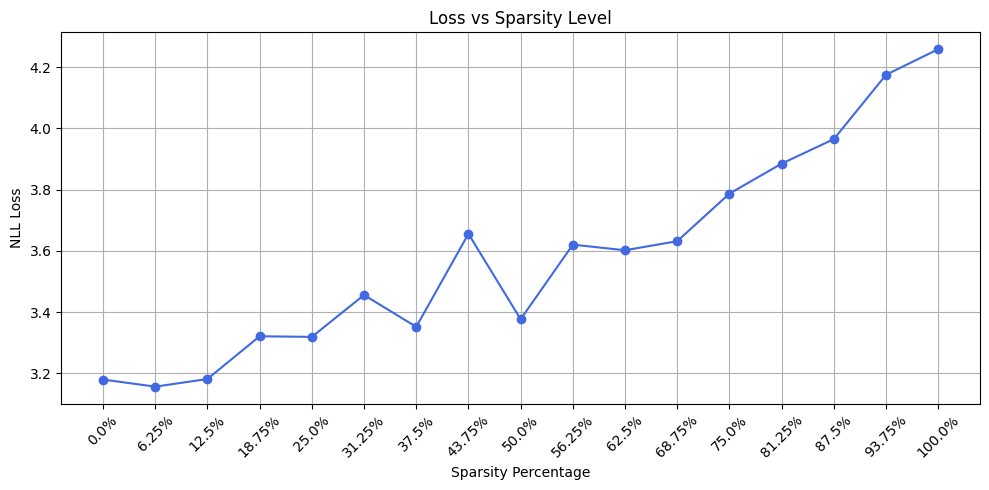

In [8]:
import matplotlib.pyplot as plt
import torch


# Convert keys and values into usable format
x_labels = list(loss_dict.keys())
x_values = [float(k.strip('%')) for k in x_labels]
y_values = [v for v in loss_dict.values()]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='royalblue')
plt.xticks(x_values, x_labels, rotation=45)
plt.xlabel('Sparsity Percentage')
plt.ylabel('NLL Loss')
plt.title('Loss vs Sparsity Level')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:

import torch
import torch.nn as nn
from torch.nn import functional as F
class TopKGate(nn.Module):
    """
    Gating network with capacity constraints, next-best assignment, and auxiliary loss
    to minimize token drops during training.
    """
    def __init__(self, input_dim, num_experts, top_k=2, capacity_factor=1.5):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.capacity_factor = capacity_factor  # 1.5 is reasonable - not too wasteful
        self.gate = nn.Linear(input_dim, num_experts, bias=True)
        nn.init.zeros_(self.gate.bias)  # Start with equal expert probability
        self.noise_epsilon = 1e-2
        
        # Auxiliary loss weights
        self.load_balance_weight = 0.01
        self.drop_penalty_weight = 1.0  # Strong penalty for drops
        self.router_balance_weight = 1e-4
        
    def calculate_expert_capacity(self, num_tokens):
        """Calculate per-expert capacity based on total tokens"""
        base_capacity = num_tokens // self.num_experts
        return int(base_capacity * self.capacity_factor)
    
    def assign_tokens_with_capacity(self, gate_probs, expert_capacity):
        """
        Assign tokens to experts with capacity constraints using next-best strategy
        
        Returns:
            assignments: tensor of shape (num_tokens,) with expert indices (-1 for dropped)
            expert_masks: tensor of shape (num_tokens, num_experts) for routing
            assignment_probs: tensor of shape (num_tokens,) with routing probabilities
        """
        num_tokens, num_experts = gate_probs.shape
        expert_counts = torch.zeros(num_experts, device=gate_probs.device, dtype=torch.long)
        assignments = torch.full((num_tokens,), -1, device=gate_probs.device, dtype=torch.long)
        assignment_probs = torch.zeros(num_tokens, device=gate_probs.device)
        
        # Sort all tokens by their maximum gate probability (process confident assignments first)
        max_probs, _ = gate_probs.max(dim=1)
        sorted_token_indices = torch.argsort(max_probs, descending=True)
        dropped_tokens_count = 0
        
        for token_idx in sorted_token_indices:
            token_probs = gate_probs[token_idx]
            # Get all experts sorted by preference (not just top-k)
            expert_preferences = torch.argsort(token_probs, descending=True)
            
            assigned = False
            
            # First, try the top-k experts
            for rank, expert_idx in enumerate(expert_preferences[:self.top_k]):
                if expert_counts[expert_idx] < expert_capacity:
                    assignments[token_idx] = expert_idx
                    assignment_probs[token_idx] = token_probs[expert_idx]
                    expert_counts[expert_idx] += 1
                    assigned = True
                    break
            
            # If top-k experts are all full, try next-best available experts
            if not assigned:
                dropped_tokens_count += 1
                for expert_idx in expert_preferences[self.top_k:]:
                    if expert_counts[expert_idx] < expert_capacity:
                        assignments[token_idx] = expert_idx
                        assignment_probs[token_idx] = token_probs[expert_idx]
                        expert_counts[expert_idx] += 1
                        assigned = True
                        break
            
            # If still not assigned, token will be dropped (assignments[token_idx] remains -1)
        
        # Create expert masks for routing
        expert_masks = torch.zeros(num_tokens, num_experts, device=gate_probs.device)
        valid_assignments = assignments >= 0
        expert_masks[valid_assignments, assignments[valid_assignments]] = 1.0
        
        return assignments, expert_masks, assignment_probs, expert_counts,dropped_tokens_count
    
    def calculate_auxiliary_losses(self, gate_probs, assignments, expert_counts,dropped_tokens_count):
        """Calculate all auxiliary losses"""
        num_tokens = gate_probs.shape[0]
        
        # 1. Load Balance Loss (encourage uniform expert usage)
        mean_gate = gate_probs.mean(dim=0)
        cv_squared = gate_probs.var(dim=0) / (mean_gate + 1e-8)
        load_balance_loss = cv_squared.mean()
        
        # 2. Drop Penalty Loss (heavily penalize dropped tokens)
        num_dropped = (assignments == -1).sum().float()
        drop_rate = dropped_tokens_count / num_tokens
        drop_penalty_loss = drop_rate  # Linear penalty on drop rate
        
        # 3. Capacity Utilization Loss (encourage using available capacity)
        target_capacity = num_tokens // self.num_experts
        capacity_diff = expert_counts.float() - target_capacity
        capacity_imbalance = (capacity_diff ** 2).mean()
        
        # 4. Router Z-Loss (from PaLM paper - prevents logit scale explosion)
        router_z_loss = torch.logsumexp(gate_probs, dim=-1).pow(2).mean()
        
        return {
            'load_balance_loss': load_balance_loss,
            'drop_penalty_loss': drop_penalty_loss,
            'capacity_imbalance': capacity_imbalance,
            'router_z_loss': router_z_loss,  # Small weight
            'drop_rate': drop_rate,
            'num_dropped': num_dropped.item(),
            'num_dropped_pre_next_best': dropped_tokens_count
        }
    
    def forward(self, x):
        """
        Forward pass with capacity constraints
        
        Returns:
            expert_masks: (batch_size * seq_len, num_experts) - binary masks for routing
            assignment_probs: (batch_size * seq_len,) - probabilities for assigned experts
            aux_losses: dict of auxiliary losses and metrics
        """
        batch_size, seq_len, input_dim = x.shape
        num_tokens = batch_size * seq_len
        x_flat = x.view(-1, input_dim)
        
        # Calculate expert capacity
        expert_capacity = self.calculate_expert_capacity(num_tokens)
        
        # Gate computation
        gate_logits = self.gate(x_flat)
        
        # Add noise during training for exploration
        if self.training:
            gate_logits += torch.randn_like(gate_logits) * self.noise_epsilon
        
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # Assign tokens to experts with capacity constraints
        assignments, expert_masks, assignment_probs, expert_counts, dropped_tokens_count = self.assign_tokens_with_capacity(gate_probs, expert_capacity)
        
        # Calculate auxiliary losses
        aux_losses = self.calculate_auxiliary_losses(gate_probs, assignments, expert_counts,dropped_tokens_count)
        effective_lb_weight = self.load_balance_weight * (self.top_k / 2) # Scale based on top_k

        # Combine losses with weights
        total_aux_loss = (
            effective_lb_weight * aux_losses['load_balance_loss'] +
            self.drop_penalty_weight * aux_losses['drop_penalty_loss'] +
             self.router_balance_weight * aux_losses['router_z_loss']
        )
        aux_losses['total_aux_loss'] = total_aux_loss
        # Monitor drop rates
        # if aux_losses['drop_rate'] > 0.05:  # More than 5% drops
        #     print(f"Warning: High drop rate {aux_losses['drop_rate']:.2%}")
        
        return expert_masks, assignment_probs, aux_losses





# class SparseMoE(nn.Module):
#     """Sparse Mixture of Experts Layer"""
#     def __init__(self, input_dim, head_size, output_dim, num_experts=8, top_k=2, 
#                  capacity_factor=1.5, dropout=0.1):
#         super(SparseMoE, self).__init__()
#         self.num_experts = num_experts
#         self.top_k = top_k
#         self.input_dim = input_dim
#         self.output_dim = output_dim
        
#         # Create expert networks
#         self.experts = nn.ModuleList([
#             Expert(head_size, output_dim) 
#             for _ in range(num_experts)
#         ])
        
#         # Gating network
#         self.gate = TopKGate(input_dim, num_experts, top_k, capacity_factor)
        
#     def forward(self, x):
#         batch_size, seq_len, input_dim = x.shape
#         x_flat = x.view(-1, input_dim)  # (batch_size * seq_len, input_dim)
        
#         # Get routing decisions from gate
#         # expert_indices, expert_weights, balance_loss = self.gate(x)
#         expert_masks, assignment_probs, aux_losses = self.gate(x)
        
#         # Initialize output
#         output = torch.zeros(x_flat.shape[0], self.output_dim, 
#                            device=x.device, dtype=x.dtype)

        
#         # Process tokens through assigned experts
#         for expert_idx, expert in enumerate(self.experts):
#             # Find tokens assigned to this expert
#             expert_tokens = expert_masks[:, expert_idx] > 0
#             if expert_tokens.any():
#                 # Get tokens for this expert
#                 tokens = x_flat[expert_tokens]
#                 # Process through expert
#                 expert_output = expert(tokens)
#                 # Weight by assignment probability
#                 weights = assignment_probs[expert_tokens].unsqueeze(-1)
#                 # Add to final output
#                 output[expert_tokens] += expert_output * weights
        
#         return output.view(batch_size, seq_len, -1), aux_losses


In [10]:

class SparseMoE(nn.Module):
    """Sparse Mixture of Experts Layer"""
    def __init__(self, input_dim, head_size, output_dim, num_experts=8, top_k=2, 
                 capacity_factor=1.5, dropout=0.1):
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Create expert networks
        self.experts = nn.ModuleList([
            Expert(head_size, output_dim) 
            for _ in range(num_experts)
        ])
        
        # Gating network
        self.gate = TopKGate(input_dim, num_experts, top_k, capacity_factor)
        
    def forward(self, x):

        batch_size, seq_len, input_dim = x.shape
        
        
        x_flat = x.view(-1, input_dim)  # (batch_size * seq_len, input_dim)
        
        # Get routing decisions from gate
        expert_masks, expert_weights, aux_losses = self.gate(x)
        
        # Initialize output
        output = torch.zeros(x_flat.shape[0], self.output_dim, 
                           device=x.device, dtype=x.dtype)
        
        # # Process each expert
        # for i, expert in enumerate(self.experts):
        #     # Find tokens assigned to this expert



        for expert_idx, expert in enumerate(self.experts):
            # Find tokens assigned to this expert
            expert_tokens = expert_masks[:, expert_idx] > 0
            # Create binary mask for the expert
            binary_mask =expert_masks[:,expert_idx].float().unsqueeze(-1) # expert_masks[:, expert_idx] > 0 #(expert_indices == i).any(dim=-1).float().unsqueeze(-1)  # [128, 1]


            # if expert_tokens.any():
            #     # Get tokens for this expert
            #     print(binary_mask.shape)
            #     print(x_flat.shape)
            #     tokens =  x_flat * binary_mask #x_flat[expert_tokens]
            #     # Process through expert
            #     expert_output = expert(tokens)
            #     print(tokens.shape)
            #     # Weight by assignment probability
            #     weights = assignment_probs[expert_tokens].unsqueeze(-1)
            #     # Add to final output
            #     output[expert_tokens] += expert_output * weights
        
            
            if expert_tokens.any():
                # Get tokens for this expert
                # expert_input = x_flat[expert_mask]
                # Apply the mask to keep shape
                expert_input = x_flat * binary_mask # [128, 64]
                # print(expert_indices.shape)
                # print(x_flat.shape)
                # print(expert_input.shape)
                
                # Get weights for this expert
                token_indices = torch.where(expert_tokens)[0]
                # print(expert_weights.shape)
                expert_output = expert(expert_input.view(batch_size, seq_len, self.output_dim))
                expert_output = expert_output.view(-1, self.output_dim)
                weights = (expert_weights.unsqueeze(-1) * binary_mask) * expert_output
                output[expert_tokens] += weights[expert_tokens] 
                
                
                # # Weight the expert output
                # for j, token_idx in enumerate(token_indices):
                #     # Find which position this expert is in for this token
                #     expert_positions = (expert_indices[token_idx] == i).nonzero(as_tuple=True)[0]
                    
                #     if len(expert_positions) > 0:
                #         weight = expert_weights[token_idx, expert_positions[0]]
                #         output[token_idx] += weight * expert_output[j]
        
        # Reshape back to original shape
        output = output.view(batch_size, seq_len, self.output_dim)
        
        return output, aux_losses

In [11]:


# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 2#000
eval_interval = 100
learning_rate =  1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50
n_embd = 64
num_experts = n_head = 8
top_k =3
#n_head = 2
n_layer = 4
dropout = 0.0


training = True
# ------------

torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss,total_loss,_ = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Expert(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size,output_dim):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(head_size, output_dim)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        out = self.proj(out)
        
        return out

# class MultiHeadAttention(nn.Module):
#     """ multiple heads of self-attention in parallel """

#     def __init__(self, num_heads, head_size):
#         super().__init__()
#         self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
#         self.proj = nn.Linear(n_embd, n_embd)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         out = torch.cat([h(x) for h in self.heads], dim=-1)
#         out = self.dropout(self.proj(out))
#         return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = SparseMoE(n_embd, head_size, n_embd, num_experts, top_k, dropout=dropout)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)


    def forward(self, x):
        moe_out, aux_metrics = self.sa(self.ln1(x))
        x = x + moe_out
        x = x + self.ffwd(self.ln2(x))
        return x, aux_metrics


# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        total_aux_loss = 0.0
        aux_metrics = {'drop_rate': 0.0, 'load_balance': 0.0, 'total_aux_loss': 0.0}

        for i, block in enumerate(self.blocks):
            x, block_metrics = block(x)
            layer_weight = (i + 1) / len(self.blocks)
            total_aux_loss += (block_metrics['total_aux_loss'] * layer_weight)
            
            # Optionally track per-block metrics
            aux_metrics['drop_rate'] += block_metrics['drop_rate']
            aux_metrics['load_balance'] += block_metrics['load_balance_loss']
        
        # Average metrics across blocks
        aux_metrics = {k: v / len(self.blocks) for k, v in aux_metrics.items()}
        aux_metrics['total_aux_loss'] = total_aux_loss
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
            total_loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            total_loss = loss + total_aux_loss #aux_metrics['total_aux_loss']

        return logits, loss,total_loss,aux_metrics

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss,total_loss,_ = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
    # Count parameters
total_params = sum(p.numel() for p in model.parameters()) / 1e6

expert_params_model = sum(p.numel() for expert in model.blocks[0].sa.experts for p in expert.parameters()) 
total_moe_params_model = sum(p.numel() for p in model.blocks[0].sa.parameters()) 
gate_params = sum(p.numel() for p in model.blocks[0].sa.gate.parameters()) 


# Dense FFN equivalent
dense_ffn_params = n_embd + (4 * (n_embd**2))

print(f"Gate parameters: {gate_params:,}")

print(f"Dense MultiHeadAttention parameters: {dense_ffn_params:,}")
print(f"Equivalent experts: {total_moe_params / dense_ffn_params:.1f}")

print(f"Total MoE parameters from model: {total_moe_params_model:,}")
print(f"Parameters For all experts from model (layer 0): {expert_params_model:,}")
print(f"Parameters per expert (layer 0) from model: {expert_params_model // num_experts:,}")


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_dict = {}
for i in range(num_experts+1):
    top_k = i
    
    for iter in range(max_iters):
    
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
        # sample a batch of data
        xb, yb = get_batch('train')
    
        # evaluate the loss
        logits, loss, total_loss,aux_metrics = model(xb, yb)
        
        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()
        optimizer.step()

    sparsity = round(((num_experts-top_k)/num_experts) * 100, 2)
    drop_rate = aux_metrics['drop_rate']
    print(f"At Sparsity {sparsity}%, Loss at {max_iters} is: {loss}")
    expert_params = sum(p.numel() for expert in model.blocks[0].sa.experts for p in expert.parameters()) 
    print(f"Parameters of Top {top_k} out of {num_experts} Experts with Drop Rate of {drop_rate}: {(expert_params // num_experts)*top_k:,}")

    loss_dict[f"{sparsity}%"] = loss.item()

# generate from the model
training = False
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.213601 M parameters
Gate parameters: 520
Dense MultiHeadAttention parameters: 16,448
Equivalent experts: 2.1
Total MoE parameters from model: 17,416
Parameters For all experts from model (layer 0): 16,896
Parameters per expert (layer 0) from model: 2,112
At Sparsity 100.0%, Loss at 2 is: 4.331852912902832
Parameters of Top 0 out of 8 Experts with Drop Rate of 0.0: 0
At Sparsity 87.5%, Loss at 2 is: 3.9932351112365723
Parameters of Top 1 out of 8 Experts with Drop Rate of 0.0009765625: 2,112
At Sparsity 75.0%, Loss at 2 is: 3.648714303970337
Parameters of Top 2 out of 8 Experts with Drop Rate of 0.01220703125: 4,224
At Sparsity 62.5%, Loss at 2 is: 3.580791473388672
Parameters of Top 3 out of 8 Experts with Drop Rate of 0.01513671875: 6,336
At Sparsity 50.0%, Loss at 2 is: 3.506544351577759
Parameters of Top 4 out of 8 Experts with Drop Rate of 0.0166015625: 8,448
At Sparsity 37.5%, Loss at 2 is: 3.3448872566223145
Parameters of Top 5 out of 8 Experts with Drop Rate of 0.01513671875: 

In [12]:
# sum(p.numel() for expert in model.blocks[0].sa.experts for p in expert.parameters()) 

In [13]:
# step 4999: train loss 1.6876, val loss 1.8470
